<h1 style="color: #002c77; font-size: 28px"> KNN Regression - Auomobile dataset</h1>

<hr>

<h2> Import libraries </h2>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

<hr>

<h2> Load dataset </h2>

In [2]:
## Setting the name of the dataset columns
col = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_doors', 'body_style', 'drive_wheels', 'engine_location', 
       'wheel_base','length', 'width', 'height', 'curb_weight', 
       'engine_type', 'num_cylinders', 'engine_size', 
       'fuel_system', 'bore', 'stroke','compression_ratio', 
       'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']

rCars = pd.read_csv(r'imports-85.data', names = col)

<hr>

<h2> Data Manipulation </h2>

<h3> Filtering columns </h3>

First, let's determine the columns which hold numeric datatypes (i.e. columns that can be used as features), which are the following:
- normalized_losess
- wheel_base
- length
- width
- height
- curb_weight
- engine_size
- bore
- stroke
- compression_ratio
- horsepower
- peak_rpm
- city_mpg
- highway_mpg
- **price (target feature)**

In [3]:
## Copy of the dataset
tCars = rCars.copy()

## Drop all the columns that cannot be used as features
col_of_interest = ['normalized_losses', 'wheel_base', 
                   'length', 'width', 'height', 'curb_weight', 
                   'engine_size', 'bore', 'stroke',
                   'compression_ratio', 'horsepower', 'peak_rpm',
                   'city_mpg', 'highway_mpg', 'price']

## Please, note that some columns can be treated to hold numeric information
# such as num_doors column (i.e instead of two we can replace it by 2)
tCars = tCars[col_of_interest]

<h3> Data cleaning </h3>

In [4]:
tCars.head(2)

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500


The dataframe slice above shows that the normalized_losses column has a special character (?). Just to be sure, let's also check all the columns if they contain any weird character at all

In [5]:
## Checking weird characters ##
special_charac = ["\?", ",", "-", "*", "\$", "#", "@", "!"]
for col in tCars.columns:
    for charac in special_charac:
        try:
            freq_cases = len(tCars[tCars[col].str.contains(charac)])
            if freq_cases != 0:
                print('In the column', col, 'there is', 
                      freq_cases,
                      'cases with the character', charac)
        except:
            pass

In the column normalized_losses there is 41 cases with the character \?
In the column bore there is 4 cases with the character \?
In the column stroke there is 4 cases with the character \?
In the column horsepower there is 2 cases with the character \?
In the column peak_rpm there is 2 cases with the character \?
In the column price there is 4 cases with the character \?


In [6]:
## Treating the above columns ##
treat_col = ['normalized_losses', 'bore', 'stroke', 'horsepower',
             'peak_rpm', 'price']

for col in treat_col:
    print('Treating', col, 'column')
    print('  Replacing question mark with null', end = '...')
    tCars[col] = (tCars[col].replace('?', np.nan))
    print('Ok')
    print('  Converting column to float dtype', end = '...')
    tCars[col] = tCars[col].astype(np.float64)
    print('Ok')

Treating normalized_losses column
  Replacing question mark with null...Ok
  Converting column to float dtype...Ok
Treating bore column
  Replacing question mark with null...Ok
  Converting column to float dtype...Ok
Treating stroke column
  Replacing question mark with null...Ok
  Converting column to float dtype...Ok
Treating horsepower column
  Replacing question mark with null...Ok
  Converting column to float dtype...Ok
Treating peak_rpm column
  Replacing question mark with null...Ok
  Converting column to float dtype...Ok
Treating price column
  Replacing question mark with null...Ok
  Converting column to float dtype...Ok


In [7]:
## Check missing values for all columns
tCars.isnull().sum()

normalized_losses    41
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_size           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

In [8]:
## Price column ##
# Since it is our target column, we will drop any row that has missing value
tCars = tCars[tCars['price'].notnull()]

## Other columns ##
# For all of the features column, we will replace the missing values with the
# mean of the column
tCars.fillna(tCars.mean(), inplace = True)

In [9]:
tCars.isnull().sum()

normalized_losses    0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_size          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
price                0
dtype: int64

In [10]:
## Normalizing all the feature columns so they have a range between 0 and 1
# Instantiate class
scaler = MinMaxScaler()

features_col = tCars.drop('price', axis = 1)

tCars_normalized = ((tCars - tCars.min()) / 
                    (tCars.max() - tCars.min()))

tCars_normalized['price'] = tCars['price']

<hr>

<h2> Univariate KNN </h2>

In [11]:
def knn_train_test(k, features_column, target_column, dataframe):
    ## Instantiate KNN class
    knn = KNeighborsRegressor(n_neighbors = k)
    np.random.seed(1)
    
    ## Randomize order of rows in the dataset
    shuffled_index = np.random.permutation(dataframe.index)
    random_dataframe = dataframe.reindex(shuffled_index)
    
    ## Define train size as 70% of the dataset length
    train_size_perc = 0.5
    train_size = int(len(dataframe)*train_size_perc)
    
    train_dataframe = dataframe[:train_size]
    test_dataframe = dataframe[train_size:]
    
    ## Fit knn model
    knn.fit(train_dataframe[[features_column]], 
            train_dataframe[[target_column]])
    
    ## Predict output
    predictions = knn.predict(test_dataframe[[features_column]])
    
    ## Calculate the rmse
    mse = mean_squared_error(test_dataframe[[target_column]], predictions)
    
    rmse = mse**(1/2)
    
    return rmse

In [12]:
## Running univariate model for different training columns
results = []
for col in tCars.drop('price', axis = 1).columns:
    for k in [1, 3, 5, 7, 9]:
        results.append([col, k,
                        knn_train_test(k,
                                       features_column = col,
                                       target_column = 'price',
                                       dataframe = tCars_normalized)])
df_result = pd.DataFrame(results, columns = ['feature', 'k', 'rmse'])
df_result.sort_values(by = 'rmse')

,feature,k,rmse
54,horsepower,9,3461.132024
53,horsepower,7,3821.376566
69,highway_mpg,9,4029.962271
34,engine_size,9,4056.629360
68,highway_mpg,7,4112.387803
33,engine_size,7,4114.571308
32,engine_size,5,4190.433888
52,horsepower,5,4267.730361
63,city_mpg,7,4575.950005
67,highway_mpg,5,4628.793094


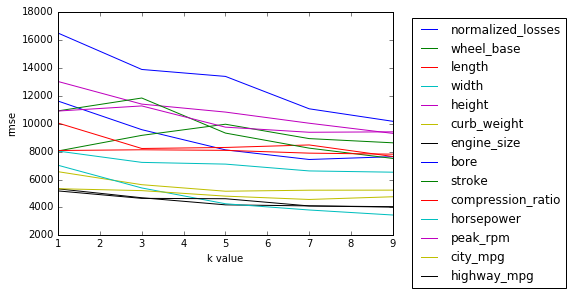

In [13]:
for feature in df_result['feature'].unique():
    df = df_result[df_result['feature'] == feature]
    x = df['k'].unique()
    y = df['rmse']
    plt.plot(x,y, label = feature)
    plt.xlabel('k value')
    plt.ylabel('rmse')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

<h2> Multivariate KNN </h2>

In [14]:
def knn_train_test(k, features_column, target_column, dataframe):
    ## Instantiate KNN class
    knn = KNeighborsRegressor(n_neighbors = k)
    np.random.seed(1)
    
    ## Randomize order of rows in the dataset
    shuffled_index = np.random.permutation(dataframe.index)
    random_dataframe = dataframe.reindex(shuffled_index)
    
    ## Define train size as 70% of the dataset length
    train_size_perc = 0.5
    train_size = int(len(dataframe)*train_size_perc)
    
    train_dataframe = dataframe[:train_size]
    test_dataframe = dataframe[train_size:]
    
    ## Fit knn model
    knn.fit(train_dataframe[features_column], 
            train_dataframe[[target_column]])
    
    ## Predict output
    predictions = knn.predict(test_dataframe[features_column])
    
    ## Calculate the rmse
    mse = mean_squared_error(test_dataframe[[target_column]], predictions)
    
    rmse = mse**(1/2)
    
    return rmse

In [24]:
k_rmse_results = {}

two_best_features = ['horsepower', 'highway_mpg']
k_rmse_results['two_best_features'] = knn_train_test(k = 5, 
                                                     features_column = two_best_features,
                                                     target_column = 'price', 
                                                     dataframe = tCars_normalized)

three_best_features = two_best_features + ['engine_size']
k_rmse_results['three_best_features'] = knn_train_test(k = 5,
                                                       features_column = three_best_features,
                                                       target_column = 'price',
                                                       dataframe = tCars_normalized)

four_best_features = three_best_features + ['city_mpg']
k_rmse_results['four_best_features'] = knn_train_test(k=5,
                                                      features_column = four_best_features,
                                                      target_column = 'price',
                                                      dataframe = tCars_normalized)

five_best_features = four_best_features + ['curb_weight']
k_rmse_results['five_best_features'] = knn_train_test(k=5,
                                                      features_column = five_best_features,
                                                      target_column = 'price',
                                                      dataframe = tCars_normalized)
print(k_rmse_results)

{'two_best_features': 3315.649835027042, 'four_best_features': 3522.3663084201035, 'three_best_features': 3547.0929270137945, 'five_best_features': 3874.9103686088624}


In [25]:
## In this step, we will take the top 3 models in the last step and vary the
# k hyperparameter value from 1 to 25
# The top 3 models are: two_best_features, three_best_features and 
# four_best_features
top_3_models = [two_best_features, three_best_features,
                four_best_features]
model_names = ['two_best_features', 'three_best_features',
               'four_best_features']

rmse_results = []
for model, model_name in zip(top_3_models, model_names):
    for k in range(1, 26):
        rmse = knn_train_test(k,
                              features_column = model,
                              target_column = 'price',
                              dataframe = tCars_normalized)
        rmse_results.append([str(model_name), k, rmse])
        
rmse_results_df = pd.DataFrame(rmse_results, columns = ['model',
                                                        'k',
                                                        'rmse'])
rmse_results_df.sort_values(by = 'rmse')

,model,k,rmse
9,two_best_features,10,2860.396913
10,two_best_features,11,2942.991524
8,two_best_features,9,2996.751450
58,four_best_features,9,3023.413617
33,three_best_features,9,3066.435389
59,four_best_features,10,3084.247373
32,three_best_features,8,3140.391945
5,two_best_features,6,3160.140624
34,three_best_features,10,3169.445795
3,two_best_features,4,3172.342635


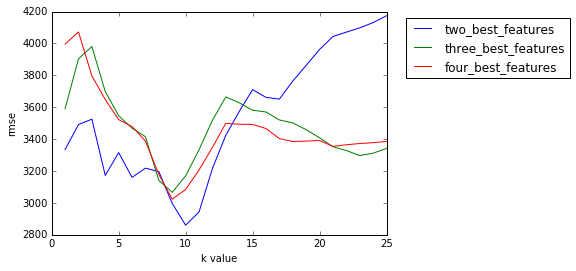

In [26]:
for model in rmse_results_df['model'].unique():
    df = rmse_results_df[rmse_results_df['model'] == model]
    x = df['k'].unique()
    y = df['rmse']
    plt.plot(x,y, label = model)
    plt.xlabel('k value')
    plt.ylabel('rmse')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

**Conclusion**
- The best model is the one that uses only 2 features (horsepower, highway_mpg) with the hyperparameter k equal to 10